**Important Notes** :
To run this you must download input file "industry-heat-demand-characterization-1.csv"
We use 1 external file to calculate the cost which is
costs_fuel_and_kwh_2010_2015.csv

Create helper function (For calculating)

In [42]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import unicodedata
from difflib import get_close_matches

# ---------- CSV Loading Helper ----------

def load_csv_permissive(path):
    """Try multiple encodings to load CSV file"""
    for enc in ("utf-8","utf-8-sig","latin1"):
        try:
            df = pd.read_csv(path, encoding=enc, low_memory=False)
            print(f"Loaded {path} with {enc}")
            return df
        except Exception:
            pass
    return pd.read_csv(path, engine="python", low_memory=False)

# ---------- Column Normalization Helpers ----------

def normalize_colname(c):
    """Normalize column names to lowercase with underscores"""
    if pd.isna(c):
        return c
    s = str(c).strip()
    s = unicodedata.normalize("NFKD", s)
    s = re.sub(r"[^\w\s]", "_", s)
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"_+", "_", s)
    return s.strip("_").lower()

def normalize_columns(df):
    """Apply column normalization to entire dataframe"""
    df = df.copy()
    df.columns = [normalize_colname(c) for c in df.columns]
    return df

Numeratic and fuel processing

In [43]:
# ---------- Numeric Coercion Helper ----------

def coerce_numeric_series(s):
    """Convert series to numeric, handling parentheses as negative"""
    s2 = s.astype(str).fillna("").str.strip()
    s2 = s2.str.replace(r"\(([^)]+)\)", r"-\1", regex=True)
    s2 = s2.str.replace(r"[^\d\.\-eE]", "", regex=True)
    return pd.to_numeric(s2.replace("", np.nan), errors="coerce")

# ---------- Fuel Detection and Standardization ----------

def detect_and_standardize_fuels(df):
    """Detect fuel columns and standardize to common names"""
    df = df.copy()
    patterns = {
        'coal': r"\bcoal\b",
        'diesel': r"\bdiesel\b",
        'lpg_ngl': r"\b(lpg|ngl|lpg_ngl|lpgngl)\b",
        'natural_gas': r"\b(natural[_\s]?gas|natural;_gas|natura[_\s;]?gas|natgas|ng)\b",
        'other_fuel': r"\b(other|misc|other_fuel)\b"
    }
    found = {}
    for std, pat in patterns.items():
        regex = re.compile(pat, flags=re.I)
        matches = [c for c in df.columns if regex.search(c)]
        if matches:
            vals = pd.Series(0.0, index=df.index)
            for c in matches:
                vals = vals.add(coerce_numeric_series(df[c]), fill_value=0.0)
            df[std] = vals.replace({0.0: np.nan})
            found[std] = matches
        else:
            df[std] = np.nan
    return df, found

ID and unit type cleaning

In [44]:
# ---------- Facility ID Cleaning ----------

def clean_facility_id(df, id_col='facility_id'):
    """Clean and standardize facility IDs"""
    df = df.copy()
    if id_col not in df.columns:
        df[id_col] = pd.NA
    df[id_col] = df[id_col].astype(str).apply(
        lambda x: x.strip().upper() if pd.notna(x) and str(x).strip() != 'nan' else pd.NA
    )
    missing_mask = df[id_col].isna()
    if missing_mask.any():
        gen = [f"FAC_UNKNOWN_{i}" for i in range(1, missing_mask.sum()+1)]
        df.loc[missing_mask, id_col] = gen
    return df

# ---------- Unit Type Canonicalization ----------

def canonicalize_unit_type(df, unit_col_candidates=None):
    """Standardize unit type values"""
    df = df.copy()
    if unit_col_candidates is None:
        unit_col_candidates = [c for c in df.columns if 'unit' in c and 'type' in c]
    unit_col = unit_col_candidates[0] if unit_col_candidates else None
    if not unit_col:
        df['unit_type'] = pd.NA
        return df

    mapping = {
        'boiler': ['boiler', 'steam boiler', 'water tube boiler', 'fire tube boiler'],
        'turbine': ['turbine', 'steam turbine', 'gas turbine'],
        'furnace': ['furnace', 'process furnace'],
        'heater': ['heater', 'process heater'],
        'kiln': ['kiln'],
        'dryer': ['dryer'],
        'chp': ['chp', 'combined heat and power', 'cogeneration'],
        'other': ['other', 'misc']
    }

    reverse_map = {}
    for k, variants in mapping.items():
        for v in variants:
            reverse_map[v] = k

    def clean_val(v):
        if pd.isna(v):
            return pd.NA
        s = str(v).strip().lower()
        s = re.sub(r"[^\w\s]", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        if s == '':
            return pd.NA
        for variant, canon in reverse_map.items():
            if variant in s:
                return canon
        choices = list(mapping.keys())
        close = get_close_matches(s, choices, n=1, cutoff=0.8)
        if close:
            return close[0]
        return s.title()

    df['unit_type'] = df[unit_col].apply(clean_val)
    return df

Upload input file

In [45]:
# Upload your CSV file
from google.colab import files
uploaded = files.upload()
# Upload 'industry-heat-demand-characterization-csv-1.csv'

Saving costs_fuel_and_kwh_2010_2015.csv to costs_fuel_and_kwh_2010_2015 (2).csv
Saving industry-heat-demand-characterization-csv-1.csv to industry-heat-demand-characterization-csv-1 (2).csv
Saving unit_level_test_with_other.csv to unit_level_test_with_other (2).csv


Aggreation

In [46]:
def clean_and_aggregate(csv_path='industry-heat-demand-characterization-csv-1.csv',
                        unit_out_path='unit_level_with_year_v2.csv',
                        facility_out_path='facility_summary_with_year.csv',
                        conversion_factor_to_kwh=1.0,
                        year=None):

    # Load and initial processing
    p = Path(csv_path)
    if not p.exists():
        raise FileNotFoundError(f"Input CSV not found: {csv_path}")

    df = load_csv_permissive(p)
    df = normalize_columns(df)
    df = clean_facility_id(df, id_col='facility_id')

    # Handle end_use column
    if 'end_use' not in df.columns:
        src = None
        for c in ('unit_type','fuel_type','fuel'):
            if c in df.columns:
                src = c
                break
        if src:
            df['end_use'] = df[src].astype(str).fillna('').replace('nan','')
        else:
            df['end_use'] = ''

    # Canonicalize unit types
    unit_candidates = [c for c in df.columns if c in ('unit_type','unitname','unit_name')
                      or ('unit' in c and 'type' in c)]
    df = canonicalize_unit_type(df, unit_col_candidates=unit_candidates)

    # Process CO2 emissions
    if 'mmtco2e' in df.columns:
        df['mmtco2e_raw'] = coerce_numeric_series(df['mmtco2e'])
    else:
        mcols = [c for c in df.columns if 'mmt' in c and 'co2' in c]
        if mcols:
            df['mmtco2e_raw'] = coerce_numeric_series(df[mcols[0]])
        else:
            df['mmtco2e_raw'] = np.nan

    # Process heat demand
    if 'total' in df.columns:
        df['total_raw'] = coerce_numeric_series(df['total'])
    else:
        df['total_raw'] = np.nan
    df['annual_heat_demand_kwh'] = df['total_raw'] * conversion_factor_to_kwh

    # Detect and standardize fuels
    df, fuel_found = detect_and_standardize_fuels(df)
    for f in ['coal','diesel','lpg_ngl','natural_gas','other_fuel']:
        if f in df.columns:
            df[f] = coerce_numeric_series(df[f])

    # Handle unit names
    if 'unit_name' not in df.columns and 'unitname' in df.columns:
        df['unit_name'] = df['unitname']
    if 'unit_name' not in df.columns:
        df['unit_name'] = df.index.astype(str)

    return df, p  # Return for next block

Unit level aggression

In [47]:
def process_unit_level(df):
    """Aggregate to unit level and improve unit type mapping"""

    # Group and aggregate
    group_keys = ['facility_id', 'unit_name']
    agg_dict = {
        'annual_heat_demand_kwh': ('annual_heat_demand_kwh', 'sum'),
        'mmtco2e_raw': ('mmtco2e_raw', 'sum'),
        'end_use': ('end_use', lambda x: x.dropna().astype(str).mode().iloc[0]
                    if x.dropna().size>0 else '')
    }
    if 'unit_type' in df.columns:
        agg_dict['unit_type'] = ('unit_type', lambda x: x.dropna().astype(str).mode().iloc[0]
                                 if x.dropna().size>0 else pd.NA)
    for col in ('city','country'):
        if col in df.columns:
            agg_dict[col] = (col, lambda x: x.dropna().astype(str).mode().iloc[0]
                           if x.dropna().size>0 else pd.NA)

    unit_df = df.groupby(group_keys, as_index=False).agg(**agg_dict)

    # Improved unit_type canonicalization
    unit_df['unit_type_original'] = unit_df['unit_type'].astype(str)
    unit_df['unit_type_clean'] = unit_df['unit_type_original'].str.lower().str.strip()
    unit_df['unit_name_clean'] = unit_df['unit_name'].astype(str).str.lower().str.strip()

    regex_map = [
        (r'\bcp[\s\-_]?1\b', 'chp'),
        (r'\bcp[\s\-_]?pse1\b', 'heater'),
        (r'\bcp[\s\-_]?pse\b', 'heater'),
        (r'\bcp\b', 'chp'),
        (r'\bboiler\b', 'boiler'),
        (r'\breboiler\b', 'boiler'),
        (r'\bhot[_\s\-]?oil\b', 'heater'),
        (r'\bheater\b', 'heater'),
        (r'\bpreheater\b', 'heater'),
        (r'\bdryer\b', 'dryer'),
        (r'\bfurnace\b', 'furnace'),
        (r'\bkiln\b', 'kiln'),
        (r'\bincinerator\b', 'furnace'),
        (r'\bcogen\b|\bchp\b|\bcombined heat\b', 'chp'),
        (r'\bclaus\b', 'furnace'),
        (r'\bgp[-_\s]?ng\b', 'boiler'),
        (r'\bgp[-_\s]?rfg\b', 'boiler'),
        (r'\bgp[-_\s]?cogens\b', 'chp'),
        (r'\bstripper\b', 'boiler'),
        (r'\breformer\b', 'heater'),
    ]

    def _map_by_regex(row):
        s = (str(row.get('unit_type_clean','')) + ' ' +
             str(row.get('unit_name_clean',''))).strip()
        for pat, canon in regex_map:
            if re.search(pat, s):
                return canon
        return None

    unit_df['unit_type_mapped'] = unit_df.apply(_map_by_regex, axis=1)

    # Handle unmapped types
    unmapped = unit_df[unit_df['unit_type_mapped'].isna()]['unit_type_clean'].value_counts().reset_index()
    unmapped.columns = ['unit_type_value','count']
    canonical_choices = ['boiler','heater','furnace','kiln','dryer','chp','turbine','other']

    def _suggest(v):
        if not v or v.strip() == '':
            return ''
        close = get_close_matches(v, canonical_choices, n=1, cutoff=0.65)
        return close[0] if close else ''

    if not unmapped.empty:
        unmapped['suggested'] = unmapped['unit_type_value'].apply(_suggest)
        try:
            unmapped.to_csv('unit_type_mapping_suggestions.csv', index=False)
        except Exception:
            pass

    suggestion_map = dict(zip(unmapped['unit_type_value'], unmapped['suggested'])) if not unmapped.empty else {}

    def _final_map(row):
        if pd.notna(row.get('unit_type_mapped')):
            return row['unit_type_mapped']
        v = row.get('unit_type_clean','')
        if v in suggestion_map and suggestion_map[v]:
            return suggestion_map[v]
        sname = row.get('unit_name_clean','')
        for pat, canon in regex_map:
            if re.search(pat, sname):
                return canon
        return 'other'

    unit_df['unit_type_mapped'] = unit_df.apply(_final_map, axis=1)
    unit_df['unit_type'] = unit_df['unit_type_mapped']

    return unit_df, regex_map

Can facility change fuel to use electricity?

In [48]:
def calculate_electrification(unit_df, df):
    """Calculate electrification feasibility scores"""

    unit_df['annual_heat_demand_kwh'] = pd.to_numeric(
        unit_df.get('annual_heat_demand_kwh', 0), errors='coerce'
    ).fillna(0.0)

    temp_col = next((c for c in unit_df.columns
                    if re.search(r"temp|degc|temperature", str(c), flags=re.I)), None)

    def unit_feasibility_score(row):
        ut = str(row.get('unit_type','')).lower()
        temp = None
        if temp_col and pd.notna(row.get(temp_col)):
            try:
                temp = float(row.get(temp_col))
            except Exception:
                temp = None
        if 'boiler' in ut:
            if temp is not None and temp <= 150:
                return 1.0
            return 0.6
        if 'heater' in ut:
            if temp is not None and temp <= 150:
                return 0.9
            if temp is not None and temp > 250:
                return 0.2
            return 0.6
        if any(x in ut for x in ['furnace','kiln']):
            if temp is not None and temp > 250:
                return 0.2
            return 0.5
        if 'dryer' in ut:
            return 0.8
        if 'chp' in ut or 'cogen' in ut:
            return 0.2
        return 0.4

    unit_df['elec_score'] = unit_df.apply(unit_feasibility_score, axis=1)
    unit_df['elec_potential_kwh'] = unit_df['annual_heat_demand_kwh'] * unit_df['elec_score']

    fac_pot = unit_df.groupby('facility_id', as_index=False).agg(
        total_energy_kwh = ('annual_heat_demand_kwh','sum'),
        potential_energy_kwh = ('elec_potential_kwh','sum')
    )
    fac_pot['potential_fraction'] = fac_pot.apply(
        lambda r: (r['potential_energy_kwh'] / r['total_energy_kwh'])
        if r['total_energy_kwh']>0 else 0.0, axis=1
    )

    def interpret_fraction(frac):
        if pd.isna(frac) or frac == 0:
            return 'No'
        if frac >= 0.8:
            return 'Yes'
        if frac >= 0.2:
            return 'Partial'
        return 'No'

    fac_pot['electrification_feasible_weighted'] = fac_pot['potential_fraction'].apply(interpret_fraction)

    # Add emissions by unit type
    if 'unit_type' in unit_df.columns:
        mmt_by_unittype = unit_df.groupby(['facility_id','unit_type'], as_index=False)['mmtco2e_raw'].sum().rename(
            columns={'mmtco2e_raw':'mmtco2e_by_unit_type_mmt'}
        )
        unit_df = unit_df.merge(mmt_by_unittype, on=['facility_id','unit_type'], how='left')
        overall_mmt_by_unittype = unit_df.groupby('unit_type', as_index=False)['mmtco2e_by_unit_type_mmt'].sum().rename(
            columns={'mmtco2e_by_unit_type_mmt':'overall_mmtco2e_by_unit_type_mmt'}
        )
        unit_df = unit_df.merge(overall_mmt_by_unittype, on='unit_type', how='left')
    else:
        unit_df['mmtco2e_by_unit_type_mmt'] = np.nan
        unit_df['overall_mmtco2e_by_unit_type_mmt'] = np.nan

    unit_df['annual_co2_tonnes'] = unit_df['mmtco2e_raw'] * 1_000_000
    unit_df['mmtco2e_by_unit_type_tonnes'] = unit_df['mmtco2e_by_unit_type_mmt'] * 1_000_000
    unit_df['overall_mmtco2e_by_unit_type_tonnes'] = unit_df['overall_mmtco2e_by_unit_type_mmt'] * 1_000_000

    return unit_df, fac_pot

Facility aggregation

In [49]:
def aggregate_facilities(unit_df, df, fac_pot):
    """Aggregate to facility level and add recommendations"""

    # Facility-level aggregation
    fac_agg = {
        'total_annual_heat_demand_kwh': ('annual_heat_demand_kwh','sum'),
        'units_count': ('unit_name','nunique'),
        'total_mmtco2e_mmt': ('mmtco2e_raw','sum'),
        'end_use': ('end_use', lambda x: x.dropna().astype(str).mode().iloc[0]
                    if x.dropna().size>0 else '')
    }
    if 'city' in unit_df.columns:
        fac_agg['city'] = ('city', lambda x: x.dropna().astype(str).mode().iloc[0]
                          if x.dropna().size>0 else pd.NA)
    if 'country' in unit_df.columns:
        fac_agg['country'] = ('country', lambda x: x.dropna().astype(str).mode().iloc[0]
                             if x.dropna().size>0 else pd.NA)

    facility = unit_df.groupby('facility_id', as_index=False).agg(**fac_agg)
    facility['annual_co2_tonnes'] = facility['total_mmtco2e_mmt'] * 1_000_000

    # Merge electrification potential
    facility = facility.merge(
        fac_pot[['facility_id','total_energy_kwh','potential_energy_kwh',
                'potential_fraction','electrification_feasible_weighted']],
        on='facility_id', how='left'
    )

    # Calculate facility total energy
    facility['facility_total_energy_kwh'] = pd.to_numeric(
        facility['total_annual_heat_demand_kwh'], errors='coerce'
    ).fillna(0.0)

    # Concentration metrics
    if 'unit_type' in unit_df.columns:
        shares = unit_df.groupby(['facility_id','unit_type'], as_index=False)['annual_heat_demand_kwh'].sum().rename(
            columns={'annual_heat_demand_kwh':'demand_by_unit_type'}
        )
        shares = shares.merge(
            facility[['facility_id','total_annual_heat_demand_kwh','facility_total_energy_kwh']],
            on='facility_id', how='left'
        )
        shares['denom'] = np.where(
            shares['facility_total_energy_kwh']>0,
            shares['facility_total_energy_kwh'],
            shares['total_annual_heat_demand_kwh'].fillna(0.0)
        )
        shares['share'] = np.where(shares['denom']>0, shares['demand_by_unit_type']/shares['denom'], 0.0)
        hhi = shares.groupby('facility_id').agg(
            concentration_hhi = ('share', lambda s: float((s.fillna(0.0)**2).sum()))
        ).reset_index()
        top1 = shares.sort_values(['facility_id','demand_by_unit_type'], ascending=[True,False]).groupby('facility_id').first().reset_index()[['facility_id','share']].rename(
            columns={'share':'percent_top1_unit_type'}
        )
        facility = facility.merge(hhi, on='facility_id', how='left').merge(top1, on='facility_id', how='left')
        facility[['concentration_hhi','percent_top1_unit_type']] = facility[['concentration_hhi','percent_top1_unit_type']].fillna(0.0)
    else:
        facility['concentration_hhi'] = 0.0
        facility['percent_top1_unit_type'] = 0.0

    if 'end_use' not in facility.columns:
        facility['end_use'] = ''

    return facility

Fuel analysis and recommendation

In [50]:
def add_fuel_analysis(facility, unit_df, df):
    """Add fuel analysis and electrification recommendations"""

    # Fuel aggregation
    fuel_input_cols = ['coal', 'diesel', 'lpg_ngl', 'natural_gas', 'other_fuel']
    for f in fuel_input_cols:
        if f not in df.columns:
            df[f] = np.nan
        else:
            df[f] = coerce_numeric_series(df[f]) if df[f].dtype == object else pd.to_numeric(df[f], errors='coerce')

    fuel_agg = df.groupby('facility_id', as_index=False)[fuel_input_cols].sum()
    fuel_agg = fuel_agg.rename(columns={'other_fuel': 'other'})

    for col in ['coal', 'diesel', 'lpg_ngl', 'natural_gas', 'other']:
        if col in fuel_agg.columns:
            if col in facility.columns:
                facility[col] = facility[col].fillna(0.0) + fuel_agg.set_index('facility_id')[col].reindex(facility['facility_id']).fillna(0.0).values
            else:
                facility[col] = fuel_agg.set_index('facility_id')[col].reindex(facility['facility_id']).fillna(0.0).values

    for c in ['coal', 'diesel', 'lpg_ngl', 'natural_gas', 'other']:
        facility[c] = pd.to_numeric(facility.get(c, 0.0), errors='coerce').fillna(0.0)

    facility['fossil_sum'] = facility[['coal', 'diesel', 'lpg_ngl', 'natural_gas']].sum(axis=1)
    facility['total_fuel'] = facility[['coal', 'diesel', 'lpg_ngl', 'natural_gas', 'other']].sum(axis=1).replace(0, np.nan)
    facility['fossil_share'] = (facility['fossil_sum'] / facility['total_fuel']).fillna(0.0)

    # Dominant unit type
    if 'unit_type' in unit_df.columns:
        dom = unit_df.groupby('facility_id', as_index=False)['unit_type'].agg(
            lambda x: x.dropna().astype(str).mode().iloc[0] if x.dropna().size>0 else pd.NA
        ).rename(columns={'unit_type': 'dominant_unit_type'})
        facility = facility.merge(dom, on='facility_id', how='left')
    else:
        facility['dominant_unit_type'] = pd.NA

    temp_col = next((c for c in facility.columns
                    if re.search(r"temp|degc|temperature", str(c), flags=re.I)), None)
    if temp_col is None:
        temp_col = next((c for c in unit_df.columns
                        if re.search(r"temp|degc|temperature", str(c), flags=re.I)), None)

    def _pick_tech(row):
        ut = str(row.get('dominant_unit_type', '') or '').lower()
        temp = None
        if temp_col and pd.notna(row.get(temp_col)):
            try:
                temp = float(row.get(temp_col))
            except Exception:
                temp = None
        if pd.isna(row.get('total_fuel')) or row.get('fossil_share', 0.0) < 0.2:
            return ('No', '')
        if 'boiler' in ut:
            if temp is not None and temp <= 150:
                return ('Yes', 'Industrial heat pump; electric boiler')
            return ('Partial', 'Electric boiler; consider hybrid heat pump if feasible')
        if any(x in ut for x in ['furnace', 'kiln', 'dryer']):
            if temp is not None and temp > 250:
                return ('Partial', 'Induction or electric resistance; high-temp heat pump (site study)')
            return ('Yes', 'Industrial heat pump; induction/electric resistance')
        if 'chp' in ut or 'cogen' in ut:
            return ('Partial', 'Grid + heat pumps or hybrid; site-specific')
        return ('Partial', 'Site-specific: evaluate heat pump, electric boiler, induction')

    facility['electrification_feasible'] = ''
    facility['recommended_electric_technology'] = ''
    for idx, row in facility.iterrows():
        feasible, tech = _pick_tech(row)
        facility.at[idx, 'electrification_feasible'] = feasible
        facility.at[idx, 'recommended_electric_technology'] = tech

    facility['electrification_feasible_old'] = facility['electrification_feasible']
    facility['electrification_feasible'] = facility['electrification_feasible_weighted'].fillna(
        facility['electrification_feasible_old']
    )

    facility['electrification_reason'] = facility.apply(
        lambda r: f"dominant_unit_type={r.get('dominant_unit_type','')}; "
                 f"fossil_share={r.get('fossil_share',0):.2f}; "
                 f"potential_fraction={r.get('potential_fraction',np.nan):.2f}", axis=1
    )

    return facility

Add year col and save

In [51]:
def add_year_and_save(unit_df, facility, df, p, unit_out_path, facility_out_path):
    """Add year information and save outputs"""

    # Look for REPORTING_YEAR in input df first
    if 'reporting_year' in df.columns:
        year_agg = df.groupby(['facility_id', 'unit_name'])['reporting_year'].agg(
            lambda x: pd.to_numeric(x, errors='coerce').mode().iloc[0] if len(x) > 0 else np.nan
        ).reset_index()
        unit_df = unit_df.merge(
            year_agg[['facility_id', 'unit_name', 'reporting_year']],
            on=['facility_id', 'unit_name'],
            how='left'
        )
        unit_df['year'] = unit_df['reporting_year']
        unit_df.drop('reporting_year', axis=1, inplace=True, errors='ignore')
    else:
        # Fallback: try to extract year from data or filename
        YEAR_MIN, YEAR_MAX = 2010, 2015
        year_col = next((c for c in df.columns if re.search(r'\byear\b', str(c), flags=re.I)), None)

        if year_col:
            yc = pd.to_numeric(df[year_col], errors='coerce').dropna().astype(int)
            yc_valid = yc[(yc >= YEAR_MIN) & (yc <= YEAR_MAX)]
            if not yc_valid.empty:
                year_val = int(yc_valid.mode().iloc[0])
            else:
                year_val = np.nan
        else:
            # Try filename
            found = re.findall(r'(\d{4})', str(p.name))
            if found:
                found_ints = [int(x) for x in found]
                found_valid = [x for x in found_ints if YEAR_MIN <= x <= YEAR_MAX]
                year_val = found_valid[0] if found_valid else np.nan
            else:
                year_val = np.nan

        unit_df['year'] = year_val

    # Drop intermediate helper columns
    drop_cols = [
        'unit_type_original', 'unit_type_clean', 'unit_name_clean',
        'unit_type_mapped', 'unit_name_mapped', 'electrification_feasible_weighted'
    ]

    for col in drop_cols:
        if col in unit_df.columns:
            unit_df.drop(columns=[col], inplace=True, errors='ignore')
        if col in df.columns:
            df.drop(columns=[col], inplace=True, errors='ignore')
        if col in facility.columns:
            facility.drop(columns=[col], inplace=True, errors='ignore')

    # Add fuel columns to unit_df
    fuel_cols = ['coal', 'diesel', 'lpg_ngl', 'natural_gas', 'other']

    # Ensure 'other' exists in df (it may be 'other_fuel')
    if 'other_fuel' in df.columns and 'other' not in df.columns:
        df['other'] = df['other_fuel']

    # Group and sum fuel usage by facility_id and unit_name
    fuel_by_unit = df.groupby(['facility_id', 'unit_name'])[fuel_cols].sum().reset_index()

    # Merge fuel data into unit_df
    unit_df = unit_df.merge(fuel_by_unit, on=['facility_id', 'unit_name'], how='left')

    # Fill NaN values with 0 for fuel columns
    for col in fuel_cols:
        if col in unit_df.columns:
            unit_df[col] = unit_df[col].fillna(0)

    # Save outputs
    unit_df.to_csv(unit_out_path, index=False)
    facility.to_csv(facility_out_path, index=False)
    print(f"Wrote cleaned unit-level to {unit_out_path} and facility-level to {facility_out_path}")

    return unit_df, facility

Run whole thing

In [52]:
# Run the complete cleaning and aggregation pipeline
print("Starting data processing pipeline...")

# Step 1: Initial loading and processing
df, p = clean_and_aggregate(
    csv_path='industry-heat-demand-characterization-csv-1.csv',
    unit_out_path='unit_level_with_year_v2.csv',
    facility_out_path='facility_summary_with_year.csv'
)

print(f"✓ Loaded and normalized {len(df)} rows")

# Step 2: Unit-level aggregation
unit_df, regex_map = process_unit_level(df)
print(f"✓ Aggregated to {len(unit_df)} units")

# Step 3: Calculate electrification feasibility
unit_df, fac_pot = calculate_electrification(unit_df, df)
print(f"✓ Calculated electrification scores")

# Step 4: Facility-level aggregation
facility = aggregate_facilities(unit_df, df, fac_pot)
print(f"✓ Aggregated to {len(facility)} facilities")

# Step 5: Add fuel analysis and recommendations
facility = add_fuel_analysis(facility, unit_df, df)
print(f"✓ Added fuel analysis and recommendations")

# Step 6: Add year and save outputs
unit_df, facility = add_year_and_save(
    unit_df, facility, df, p,
    'unit_level_with_year_v2.csv',
    'facility_summary_with_year.csv'
)
print("PROCESSING COMPLETE")
print(f"\nGenerated files:")
print(f"  • unit_level_with_year_v2.csv ({len(unit_df)} rows)")
print(f"  • facility_summary_with_year.csv ({len(facility)} rows)")

Starting data processing pipeline...
Loaded industry-heat-demand-characterization-csv-1.csv with latin1
✓ Loaded and normalized 94934 rows
✓ Aggregated to 5716 units
✓ Calculated electrification scores
✓ Aggregated to 1032 facilities
✓ Added fuel analysis and recommendations
Wrote cleaned unit-level to unit_level_with_year_v2.csv and facility-level to facility_summary_with_year.csv
PROCESSING COMPLETE

Generated files:
  • unit_level_with_year_v2.csv (5716 rows)
  • facility_summary_with_year.csv (1032 rows)


In [53]:
# Download the generated CSV files
from google.colab import files

print("\nDownloading generated files...")

files.download('unit_level_with_year_v2.csv')
files.download('facility_summary_with_year.csv')

# Download mapping suggestions if it was created
import os
if os.path.exists('unit_type_mapping_suggestions.csv'):
    files.download('unit_type_mapping_suggestions.csv')
    print("Also downloaded: unit_type_mapping_suggestions.csv")

print("\n All files downloaded successfully!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Also downloaded: unit_type_mapping_suggestions.csv

 All files downloaded successfully!


Calculate total cost for visualize

In [54]:
from google.colab import files
uploaded = files.upload()

Saving unit_level_test_with_other.csv to unit_level_test_with_other (3).csv


In [55]:
# Load datasets
try:
    # Load unit level data
    unit_df = pd.read_csv('unit_level_with_year_v2.csv')
    # Load costs data
    costs_df = pd.read_csv('costs_fuel_and_kwh_2010_2015.csv')
except FileNotFoundError as e:
    raise SystemExit(f"Error: {e}")

# Debug print to check data
print("\nUnit DataFrame Info:")
print(unit_df.info())
print("\nSample of unit_df year values:")
print(unit_df['year'].value_counts())
print("\nCosts DataFrame:")
print(costs_df)

# Clean and prepare costs data
# Split into fuel costs and electricity costs
fuel_costs = costs_df.iloc[:6, [0,1,2,3,4]].copy()
elec_costs = costs_df.iloc[8:14, [0,1]].copy()

# Clean column names
fuel_costs.columns = ['year', 'coal_cost', 'diesel_cost', 'lpg_cost', 'natural_gas_cost']
elec_costs.columns = ['year', 'electricity_cost_kwh']

# Make sure year columns are numeric
fuel_costs['year'] = pd.to_numeric(fuel_costs['year'])
elec_costs['year'] = pd.to_numeric(elec_costs['year'])
unit_df['year'] = pd.to_numeric(unit_df['year'])

# Conversion factors
CONVERSION_FACTORS = {
    'coal': 20.0,          # MMBtu per short ton
    'diesel': 0.137,       # MMBtu per gallon
    'lpg_ngl': 0.091,      # MMBtu per gallon
    'natural_gas': 1.037   # MMBtu per thousand cubic feet
}

def calculate_total_cost(row, fuel_costs_year):
    try:
        if pd.isna(row['year']):
            return np.nan

        year = int(row['year'])
        if year not in fuel_costs_year.year.values:
            return np.nan

        year_costs = fuel_costs_year[fuel_costs_year.year == year].iloc[0]
        total_cost = 0.0

        # Calculate fuel costs
        for fuel_type, conversion in CONVERSION_FACTORS.items():
            if pd.notna(row.get(fuel_type, np.nan)):
                cost_col = f"{fuel_type}_cost".replace('lpg_ngl', 'lpg')
                total_cost += float(row[fuel_type]) * float(year_costs[cost_col]) * conversion

        # Calculate electricity cost
        if pd.notna(row.get('annual_heat_demand_kwh')):
            elec_cost = float(elec_costs[elec_costs.year == year].iloc[0]['electricity_cost_kwh'])
            total_cost += float(row['annual_heat_demand_kwh']) * elec_cost

        return total_cost
    except Exception as e:
        print(f"Error calculating cost for row: {row['facility_id']}, year: {row['year']}")
        print(f"Error details: {str(e)}")
        return np.nan

# Calculate total cost for each unit
print("\nCalculating costs...")
unit_df['total_annual_cost_usd'] = unit_df.apply(
    lambda row: calculate_total_cost(row, fuel_costs), axis=1
)

# Print debug info
print("\nSample of calculated costs:")
print(unit_df[['facility_id', 'year', 'total_annual_cost_usd']].head())

# Save updated dataset
output_path = 'unit_level_with_costs.csv'
unit_df.to_csv(output_path, index=False)

# Print summary statistics
print("\nCost Summary Statistics:")
print(unit_df['total_annual_cost_usd'].describe())

# Print total costs by year
yearly_costs = unit_df.groupby('year')['total_annual_cost_usd'].agg(['sum', 'mean', 'count'])
print("\nYearly Cost Breakdown:")
print(yearly_costs)


Unit DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5716 entries, 0 to 5715
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   facility_id                          5716 non-null   int64  
 1   unit_name                            5716 non-null   object 
 2   annual_heat_demand_kwh               5716 non-null   float64
 3   mmtco2e_raw                          5716 non-null   float64
 4   end_use                              5716 non-null   object 
 5   unit_type                            5716 non-null   object 
 6   city                                 5716 non-null   object 
 7   elec_score                           5716 non-null   float64
 8   elec_potential_kwh                   5716 non-null   float64
 9   mmtco2e_by_unit_type_mmt             5716 non-null   float64
 10  overall_mmtco2e_by_unit_type_mmt     5716 non-null   float64
 11  annual_c

Make a fuel_type col

In [56]:
# Load your CSV (adjust path as needed)
df = pd.read_csv("unit_level_with_year_v2.csv")

# Columns that indicate fuel amounts (adjust if your file uses different names)
fuel_cols = ["coal", "diesel", "lpg_ngl", "natural_ga",]

# Safety: ensure columns exist and are numeric
for c in fuel_cols:
    if c not in df.columns:
        df[c] = 0.0
    else:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

# Threshold to treat tiny floating values as zero
EPS = 1e-6

# Mapping from column name to readable fuel label
LABEL_MAP = {
    "coal": "Coal",
    "diesel": "Oil (Diesel)",
    "lpg_ngl": "LPG/NGL",
    "natural_ga": "Natural Gas",

}

def row_fuel_type(row):
    found = []
    for col in fuel_cols:
        if row[col] > EPS:
            found.append(LABEL_MAP.get(col, col))
    if not found:
        return ""
    # If multiple fuels present, join with ';'
    return ";".join(found)

# Create the column
df["fuel_type"] = df.apply(row_fuel_type, axis=1)

# Optional: convert to categorical with a preferred order
preferred_order = ["Natural Gas", "Coal", "Oil (Diesel)", "LPG/NGL"]
df["fuel_type"] = pd.Categorical(df["fuel_type"], categories=preferred_order, ordered=False)

# Example: show first rows
print(df[["facility_id", "unit_name", "coal", "diesel", "lpg_ngl", "natural_ga", "fuel_type"]].head())

# Save back if desired
df.to_csv("unit_level_with_year_with_fuel.csv", index=False)

   facility_id           unit_name  coal  diesel  lpg_ngl  natural_ga  \
0      1000022              GP-Blr   0.0     0.0      0.0         0.0   
1      1000022              GP-Htr   0.0     0.0      0.0         0.0   
2      1000025       Boiler 1 4-77   0.0     0.0      0.0         0.0   
3      1000025       Boiler 2 5-77   0.0     0.0      0.0         0.0   
4      1000025  Charge Heater 2-91   0.0     0.0      0.0         0.0   

  fuel_type  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


Visual

In [57]:
# Colab cell 1: Setup and imports
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Base path for CSV files (default: current working directory in Colab)
base_path = Path('.')  # change this to Path('/content/drive/MyDrive/...') if needed

# Directory for saving figures
figures_dir = base_path / 'figures'
figures_dir.mkdir(exist_ok=True)

In [58]:
# Colab cell 2: Check required files
required_files = [
    'unit_level_with_year_v2.csv',
    'unit_level_with_costs.csv',
    'facility_summary_with_year.csv'
]

missing = [f for f in required_files if not (base_path / f).exists()]
if missing:
    raise SystemExit(f"Missing required files in {base_path}: {missing}")

print("All required files found in", base_path)
for f in required_files:
    print("-", f, ":", (base_path / f).stat().st_size, "bytes")

All required files found in .
- unit_level_with_year_v2.csv : 1471053 bytes
- unit_level_with_costs.csv : 1563802 bytes
- facility_summary_with_year.csv : 436493 bytes


In [59]:
# Colab cell 3: Shared utilities
def coerce_numeric(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def ensure_fuel_cols(df, fuel_cols):
    for c in fuel_cols:
        if c not in df.columns:
            df[c] = 0.0
    return df

<Figure size 1400x800 with 0 Axes>

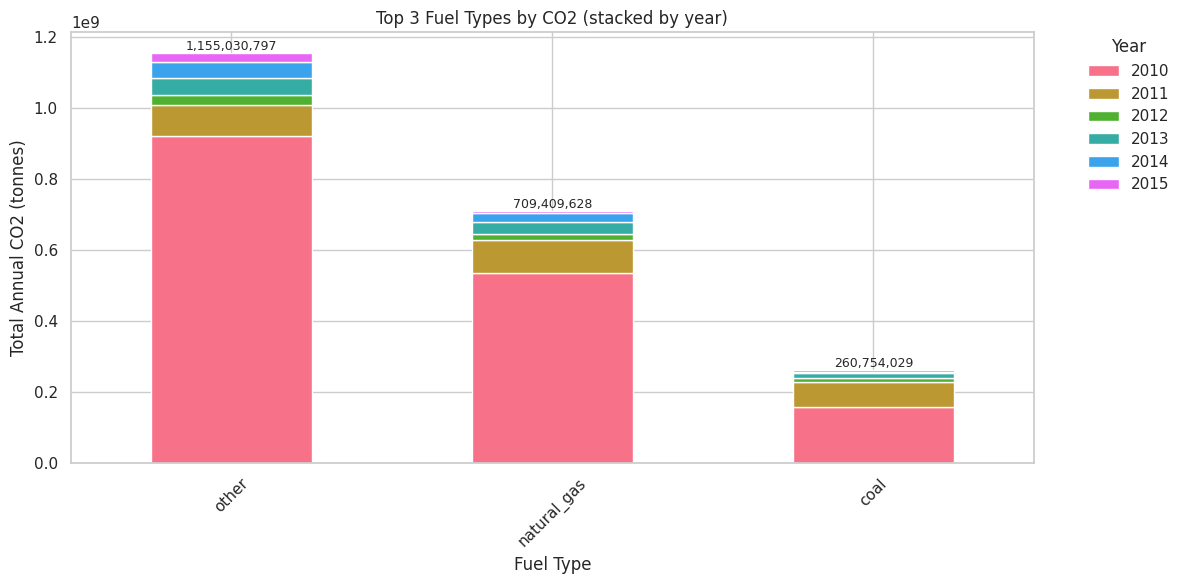

Shape of pivot table (top 3): (3, 6)
Columns in pivot table: [2010, 2011, 2012, 2013, 2014, 2015]
Unique years in dataset: [2010 2011 2015 2013 2014 2012]


In [60]:
# Colab cell 4: CO2 by fuel type stacked by year
# Path
unit_year_csv = base_path / 'unit_level_with_year_v2.csv'

# Read data
df_unit_year = pd.read_csv(unit_year_csv)

# Ensure numeric columns exist and coerce
numeric_cols = [
    'annual_co2_tonnes', 'coal', 'diesel', 'natural_gas',
    'lpg_ngl', 'other', 'total_fuel'
]
df_unit_year = coerce_numeric(df_unit_year, numeric_cols)
clean_df = df_unit_year.copy()

# Fuel columns and total fuel energy
fuel_cols = ['coal', 'diesel', 'lpg_ngl', 'natural_gas', 'other']
clean_df = ensure_fuel_cols(clean_df, fuel_cols)
clean_df['total_fuel_energy'] = clean_df[fuel_cols].sum(axis=1)

# Melt to long format and allocate CO2 proportionally
id_vars = ['facility_id', 'annual_co2_tonnes', 'year', 'total_fuel_energy']
fuel_long = clean_df[id_vars + fuel_cols].melt(
    id_vars=id_vars,
    value_vars=fuel_cols,
    var_name='fuel_type',
    value_name='fuel_energy'
)

fuel_long['co2_alloc_tonnes'] = 0.0
mask = fuel_long['total_fuel_energy'] > 0
fuel_long.loc[mask, 'co2_alloc_tonnes'] = (
    fuel_long.loc[mask, 'annual_co2_tonnes'].fillna(0) *
    (fuel_long.loc[mask, 'fuel_energy'].fillna(0) / fuel_long.loc[mask, 'total_fuel_energy'])
)

# Aggregate and pivot
co2_by_fuel_year = (
    fuel_long.groupby(['fuel_type', 'year'])['co2_alloc_tonnes']
    .sum()
    .reset_index()
)

pivot = co2_by_fuel_year.pivot(
    index='fuel_type',
    columns='year',
    values='co2_alloc_tonnes'
).fillna(0)

# Sort and plot if data exists
if not pivot.empty:
    pivot['total_co2'] = pivot.sum(axis=1)
    pivot = pivot.sort_values('total_co2', ascending=False)

    # Keep only top 3 fuel types
    pivot = pivot.head(3)

    # Drop helper column
    pivot = pivot.drop(columns='total_co2')

    plt.figure(figsize=(14, 8))
    ax = pivot.plot(kind='bar', stacked=True,
                    color=sns.color_palette('husl', len(pivot.columns)))
    ax.set_xlabel('Fuel Type')
    ax.set_ylabel('Total Annual CO2 (tonnes)')
    ax.set_title('Top 3 Fuel Types by CO2 (stacked by year)')
    plt.xticks(rotation=45)
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    totals = pivot.sum(axis=1).values
    for i, total in enumerate(totals):
        if np.isfinite(total):
            ax.text(i, total, f"{total:,.0f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    out_path = figures_dir / 'co2_by_fuel_year_top3.png'
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

print("Shape of pivot table (top 3):", pivot.shape)
print("Columns in pivot table:", pivot.columns.tolist())
print("Unique years in dataset:", clean_df['year'].unique())

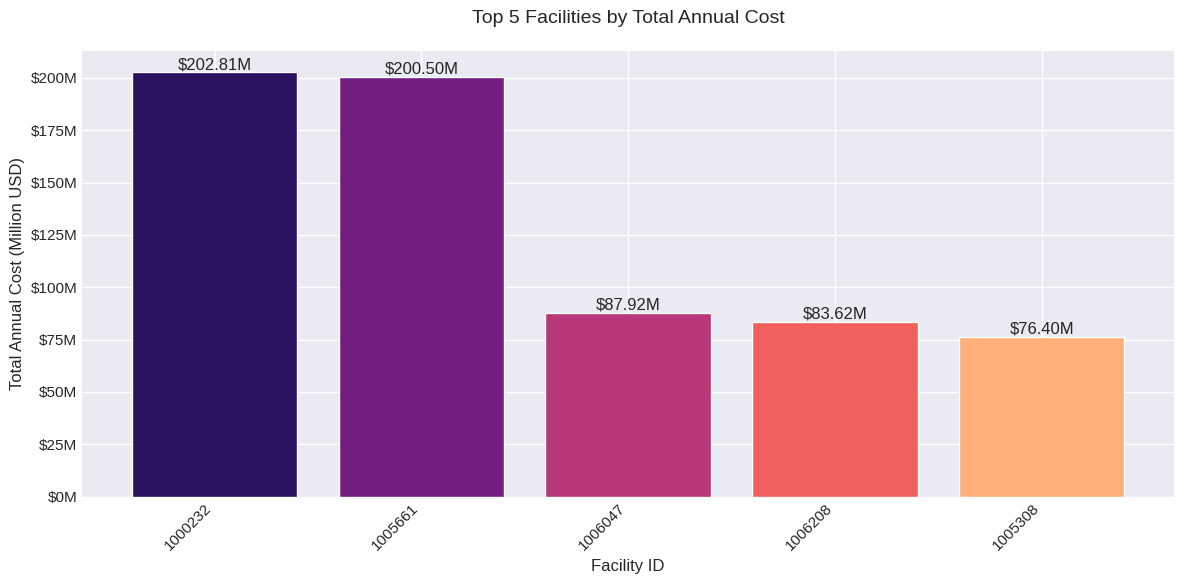


Top 5 Facilities by Total Annual Cost (in millions USD):
 facility_id  cost_millions
     1000232     202.812879
     1005661     200.499242
     1006047      87.919305
     1006208      83.619420
     1005308      76.396546


In [61]:
# Colab cell 5: Top 5 facilities by total annual cost
costs_csv = base_path / 'unit_level_with_costs.csv'

df_costs = pd.read_csv(costs_csv)

# Group and compute top 5
facility_costs = df_costs.groupby('facility_id')['total_annual_cost_usd'].sum().reset_index()
top5_facilities = facility_costs.nlargest(5, 'total_annual_cost_usd').reset_index(drop=True)

# Plot
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(top5_facilities)), top5_facilities['total_annual_cost_usd'],
               color=sns.color_palette('magma', n_colors=5))

plt.title('Top 5 Facilities by Total Annual Cost', pad=20, fontsize=14)
plt.xlabel('Facility ID', fontsize=12)
plt.ylabel('Total Annual Cost (Million USD)', fontsize=12)
plt.xticks(range(len(top5_facilities)), top5_facilities['facility_id'], rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:,.0f}M'))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height/1e6:,.2f}M',
             ha='center', va='bottom')

plt.tight_layout()
out_path = figures_dir / 'top5_facilities_by_cost.png'
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()

# Print the data
top5_facilities['cost_millions'] = top5_facilities['total_annual_cost_usd'] / 1_000_000
print("\nTop 5 Facilities by Total Annual Cost (in millions USD):")
print(top5_facilities[['facility_id', 'cost_millions']].to_string(index=False))

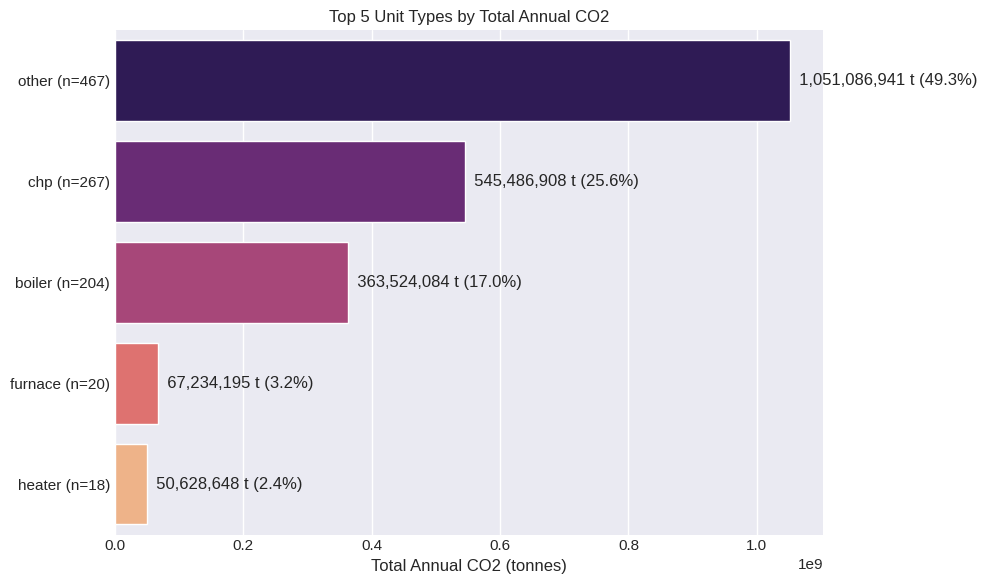

Saved improved top-5 CO2 chart to: figures/top5_unittype_co2_improved.png

Top 5 unit types and their CO2 emissions:
                      co2_tonnes  facility_count
dominant_unit_type                              
other               1.051087e+09             467
chp                 5.454869e+08             267
boiler              3.635241e+08             204
furnace             6.723419e+07              20
heater              5.062865e+07              18


In [62]:
# Colab cell 6: Top 5 unit types by total annual CO2
facility_csv = base_path / 'facility_summary_with_year.csv'

facility_df = pd.read_csv(facility_csv)

co2_by_unittype = facility_df.groupby('dominant_unit_type', dropna=False)['annual_co2_tonnes'].sum()
facility_counts = facility_df.groupby('dominant_unit_type', dropna=False)['facility_id'].nunique()

co2_summary = pd.DataFrame({
    'co2_tonnes': co2_by_unittype,
    'facility_count': facility_counts
}).fillna(0)
co2_summary = co2_summary.sort_values('co2_tonnes', ascending=False)

total_co2 = co2_summary['co2_tonnes'].sum()
if total_co2 == 0 or co2_summary.shape[0] == 0:
    print('No CO2 data available to plot.')
else:
    top5 = co2_summary.head(5)
    labels = [f"{ut} (n={int(top5.loc[ut,'facility_count'])})" for ut in top5.index]

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=top5['co2_tonnes'].values, y=labels, palette='magma')
    ax.set_xlabel('Total Annual CO2 (tonnes)')
    ax.set_title('Top 5 Unit Types by Total Annual CO2')

    for i, ut in enumerate(top5.index):
        val = top5.loc[ut, 'co2_tonnes']
        pct = (val / total_co2 * 100) if total_co2 > 0 else 0
        ax.text(val, i, f"  {val:,.0f} t ({pct:.1f}%)", va='center')

    plt.tight_layout()
    out_path = figures_dir / 'top5_unittype_co2_improved.png'
    plt.savefig(out_path, dpi=150)
    plt.show()

    print('Saved improved top-5 CO2 chart to:', out_path)
    print("\nTop 5 unit types and their CO2 emissions:")
    print(top5[['co2_tonnes', 'facility_count']].to_string())

Top 5 Facilities by Total Annual CO2 Emissions:


,facility_id,city,annual_co2_tonnes,total_annual_heat_demand_kwh,electrification_feasible
0,1000418,GARY,4.811530e+07,333073.971670,Partial
1,1007542,BAYTOWN,4.662659e+07,855240.277966,Partial
2,1003962,BURNS HARBOR,3.320170e+07,278327.270990,Partial
3,1005585,TEXAS CITY,2.949891e+07,550241.848831,Partial
4,1000156,EAST CHICAGO,2.869379e+07,167293.660551,Partial


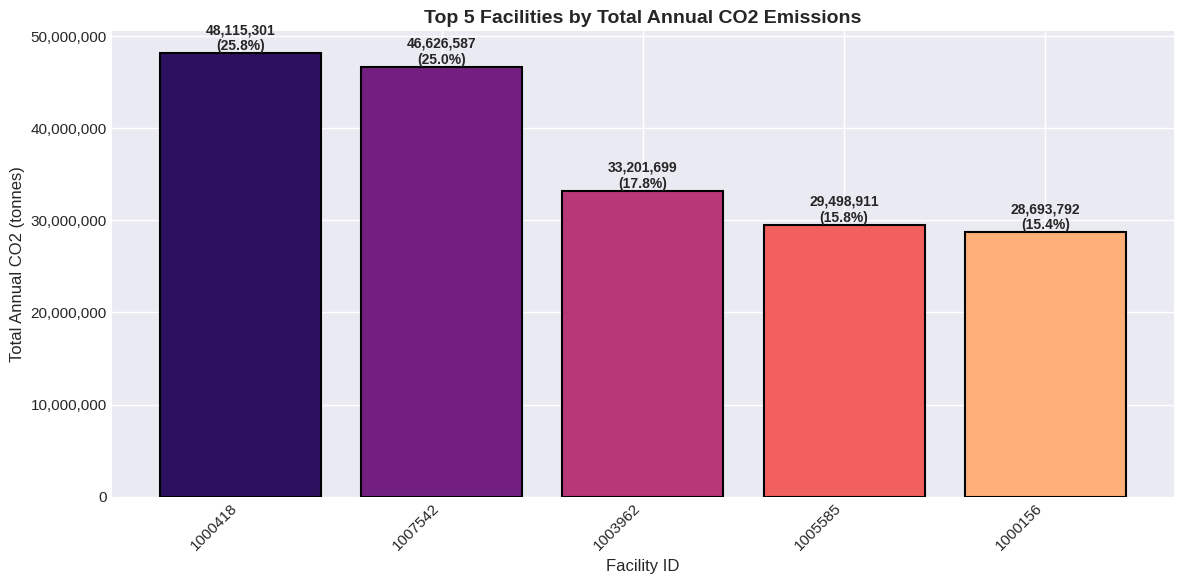


Total CO2 from top 5 facilities: 186,136,291 tonnes


In [63]:
# Get top 5 facilities by CO2 emissions
top5_facilities_co2 = facility.nlargest(5, 'annual_co2_tonnes')[ # Changed clean_df to facility
    ['facility_id', 'city', 'annual_co2_tonnes',
     'total_annual_heat_demand_kwh', 'electrification_feasible']
].reset_index(drop=True)

# Display formatted table
print("Top 5 Facilities by Total Annual CO2 Emissions:")
display(top5_facilities_co2)

# Create vertical bar chart
plt.figure(figsize=(12, 6))
ax = plt.bar(range(len(top5_facilities_co2)),
             top5_facilities_co2['annual_co2_tonnes'],
             color=sns.color_palette('magma', n_colors=5),
             edgecolor='black',
             linewidth=1.5)

plt.title('Top 5 Facilities by Total Annual CO2 Emissions', fontsize=14, fontweight='bold')
plt.xlabel('Facility ID', fontsize=12)
plt.ylabel('Total Annual CO2 (tonnes)', fontsize=12)

# Set x-ticks with facility IDs
plt.xticks(range(len(top5_facilities_co2)),
           top5_facilities_co2['facility_id'],
           rotation=45, ha='right')

# Format y-axis with thousand separators
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Calculate total CO2 for percentage calculation
total_co2 = top5_facilities_co2['annual_co2_tonnes'].sum()

# Add value labels on top of each bar with absolute value and percentage
for i, value in enumerate(top5_facilities_co2['annual_co2_tonnes']):
    percentage = (value / total_co2 * 100) if total_co2 > 0 else 0
    plt.text(i, value,
            f'{value:,.0f}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'top5_facilities_co2.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal CO2 from top 5 facilities: {total_co2:,.0f} tonnes")

Calculate mean cost (new files to avoid misvisualize)

In [64]:
import pandas as pd
import numpy as np

# Paths (assumes notebook is in the same folder as the CSVs)
UNIT_PATH = 'unit_level_with_year_v2.csv'
COSTS_PATH = 'costs_fuel_and_kwh_2010_2015.csv'
OUTPUT_PATH = 'unit_level_test_with_other.csv'

# Load files with simple error handling
try:
    unit_df = pd.read_csv(UNIT_PATH)
    costs_df = pd.read_csv(COSTS_PATH)
except FileNotFoundError as e:
    raise SystemExit(f'File not found: {e}')

# Parse costs file into fuel prices and electricity prices (keeps same slices used in other notebooks)
# Adjust these slices if your costs file structure changes
fuel_costs = costs_df.iloc[:6, [0,1,2,3,4]].copy()
elec_costs = costs_df.iloc[8:14, [0,1]].copy()
fuel_costs.columns = ['year', 'coal_cost', 'diesel_cost', 'lpg_cost', 'natural_gas_cost']
elec_costs.columns = ['year', 'electricity_cost_kwh']

# Ensure numeric years and numeric prices
fuel_costs['year'] = pd.to_numeric(fuel_costs['year'], errors='coerce')
for c in ['coal_cost','diesel_cost','lpg_cost','natural_gas_cost']:
    fuel_costs[c] = pd.to_numeric(fuel_costs[c], errors='coerce')
elec_costs['year'] = pd.to_numeric(elec_costs['year'], errors='coerce')
unit_df['year'] = pd.to_numeric(unit_df['year'], errors='coerce')

# Conversion factors (same as used in other notebook): units -> MMBtu (or other consistent multiplier)
CONVERSION_FACTORS = {
    'coal': 20.0,      # MMBtu per short ton
    'diesel': 0.137,   # MMBtu per gallon
    'lpg_ngl': 0.091,  # MMBtu per gallon
    'natural_gas': 1.037 # MMBtu per thousand cubic feet
}

 # Helper: get price row for a year (returns series)
def _get_year_costs(year):
    try:
        return fuel_costs.loc[fuel_costs['year'] == int(year)].iloc[0]
    except Exception:
        return None

def calculate_fuel_cost(row):
    year = row.get('year', np.nan)
    if pd.isna(year):
        return np.nan
    year_costs = _get_year_costs(year)
    if year_costs is None:
        return np.nan
    total = 0.0
    for fuel_type, conv in CONVERSION_FACTORS.items():
        qty = row.get(fuel_type, np.nan)
        if pd.notna(qty) and float(qty) != 0.0:
            cost_col = 'lpg_cost' if fuel_type == 'lpg_ngl' else f'{fuel_type}_cost'
            price = year_costs.get(cost_col, np.nan)
            if pd.notna(price):
                try:
                    total += float(qty) * float(price) * float(conv)
                except Exception:
                    continue
    return total

def calculate_electricity_cost(row):
    year = row.get('year', np.nan)
    if pd.isna(year):
        return np.nan
    try:
        elec_price = elec_costs.loc[elec_costs['year'] == int(year)].iloc[0]['electricity_cost_kwh']
    except Exception:
        return np.nan
    kwh = row.get('annual_heat_demand_kwh', np.nan)
    if pd.isna(kwh):
        return 0.0
    try:
        return float(kwh) * float(elec_price)
    except Exception:
        return np.nan

# Compute columns (apply row-wise)
print('Computing fuel_cost_usd (this may take a moment) ...')
unit_df['fuel_cost_usd'] = unit_df.apply(calculate_fuel_cost, axis=1)
print('Computing electricity_cost_usd ...')
unit_df['electricity_cost_usd'] = unit_df.apply(calculate_electricity_cost, axis=1)

# Compute per-year mean of the listed fuel prices and map to units
mean_prices = fuel_costs.set_index('year')[['coal_cost','diesel_cost','lpg_cost','natural_gas_cost']].mean(axis=1)
# Map mean price to each unit row
unit_df['mean_fuel_price_per_unit'] = unit_df['year'].map(mean_prices)

# Estimate cost for 'other' using mean price * other quantity (if 'other' exists)
if 'other' in unit_df.columns:
    # Ensure numeric other
    unit_df['other'] = pd.to_numeric(unit_df['other'], errors='coerce').fillna(0)
    unit_df['est_other_cost'] = unit_df['other'] * unit_df['mean_fuel_price_per_unit']
else:
    unit_df['est_other_cost'] = 0.0

# Replace zeros in fuel_cost_usd with estimated other cost where available
mask_zero = (unit_df['fuel_cost_usd'] == 0) | (unit_df['fuel_cost_usd'].isna())
unit_df.loc[mask_zero, 'fuel_cost_usd'] = unit_df.loc[mask_zero, 'est_other_cost']

# If any remaining NaN fuel_cost_usd, fill with 0 (optional)
unit_df['fuel_cost_usd'] = unit_df['fuel_cost_usd'].fillna(0)

# Target: True if electricity cost <= fuel cost, False otherwise. NaNs preserved where appropriate.
unit_df['target'] = np.where(unit_df['electricity_cost_usd'].isna() | unit_df['fuel_cost_usd'].isna(), np.nan, unit_df['electricity_cost_usd'] <= unit_df['fuel_cost_usd'])

# Save output
unit_df.to_csv(OUTPUT_PATH, index=False)

# Print short summaries
print('\nSample of results (note: zeros replaced by estimated other cost where available):')
print(unit_df[['facility_id', 'unit_name', 'year', 'other', 'fuel_cost_usd', 'electricity_cost_usd', 'target']].head(10))

print('\nTarget value counts (True means electric cost <= fuel cost):')
print(unit_df['target'].value_counts(dropna=False))

print('\nYearly sums (for quick sanity check):')
# show numeric sums - convert fuel_cost_usd to numeric for aggregation
unit_df['_fuel_cost_num'] = pd.to_numeric(unit_df['fuel_cost_usd'], errors='coerce').fillna(0)
print(unit_df.groupby('year')[['_fuel_cost_num', 'electricity_cost_usd']].sum().head())

print(f'\nWrote updated dataset to: {OUTPUT_PATH}')

Computing fuel_cost_usd (this may take a moment) ...
Computing electricity_cost_usd ...

Sample of results (note: zeros replaced by estimated other cost where available):
   facility_id                               unit_name  year        other  \
0      1000022                                  GP-Blr  2010     0.000000   
1      1000022                                  GP-Htr  2010     0.000000   
2      1000025                           Boiler 1 4-77  2010   361.093137   
3      1000025                           Boiler 2 5-77  2010   358.301683   
4      1000025                      Charge Heater 2-91  2010    98.118576   
5      1000025                   Crude Heater 1-74 A&B  2010  1307.667136   
6      1000025                     FCCU Preheater 1-85  2010   157.245068   
7      1000025                        GP-Claus Burners  2010     0.000000   
8      1000025  GP-Cogens and Enclosed Vapor Combustor  2010     0.000000   
9      1000025                                   GP-NG  201

Double check

In [65]:
# Diagnostic: Look at rows with zero fuel cost but non-zero fuel usage
zero_fuel_cost = unit_df[unit_df['fuel_cost_usd'] == 0]
print('\nRows with zero fuel cost:')
cols = ['facility_id', 'unit_name', 'year', 'coal', 'diesel', 'lpg_ngl', 'natural_gas', 'other', 'fuel_cost_usd']
print(zero_fuel_cost[cols].head())

print('\nSample row details to debug fuel cost calculation:')
sample_row = zero_fuel_cost.iloc[0] if not zero_fuel_cost.empty else unit_df.iloc[0]
print('\nFuel quantities:')
for fuel in ['coal', 'diesel', 'lpg_ngl', 'natural_gas']:
    print(f"{fuel}: {sample_row.get(fuel, 'N/A')}")

year = sample_row['year']
if not pd.isna(year):
    print(f"\nFuel prices for year {int(year)}:")
    year_costs = fuel_costs[fuel_costs['year'] == int(year)]
    if not year_costs.empty:
        print(year_costs.iloc[0])


Rows with zero fuel cost:
    facility_id                        unit_name  year  coal  diesel  lpg_ngl  \
42      1000156                    GP-IHE_Diesel  2010   0.0     0.0      0.0   
67      1000166  No. 2 Package Boiler, 11-CU-033  2010   0.0     0.0      0.0   
75      1000177                            CP-04  2010   0.0     0.0      0.0   
77      1000177                            CP-06  2010   0.0     0.0      0.0   
80      1000177          CP-09 (Steel Finishing)  2010   0.0     0.0      0.0   

    natural_gas  other  fuel_cost_usd  
42          0.0    0.0            0.0  
67          0.0    0.0            0.0  
75          0.0    0.0            0.0  
77          0.0    0.0            0.0  
80          0.0    0.0            0.0  

Sample row details to debug fuel cost calculation:

Fuel quantities:
coal: 0.0
diesel: 0.0
lpg_ngl: 0.0
natural_gas: 0.0

Fuel prices for year 2010:
year                2010.00
coal_cost             39.00
diesel_cost            2.88
lpg_cost    

# **Model**

# import

In [66]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('unit_level_test_with_other.csv')

Check first few rows and info

In [67]:
# Check out your data
print("First few rows:")
print(df.head())
print("\nBasic info:")
print(df.info())

First few rows:
   facility_id           unit_name  annual_heat_demand_kwh  mmtco2e_raw  \
0      1000022              GP-Blr             2222.388013     0.111882   
1      1000022              GP-Htr             1118.152596     0.056291   
2      1000025       Boiler 1 4-77              361.093137     0.020280   
3      1000025       Boiler 2 5-77              358.301683     0.020123   
4      1000025  Charge Heater 2-91               98.118576     0.005511   

                           end_use unit_type        city  elec_score  \
0  CHP and/or Cogeneration Process     other  TEXAS CITY         0.4   
1  CHP and/or Cogeneration Process     other  TEXAS CITY         0.4   
2  CHP and/or Cogeneration Process    boiler  PORT ALLEN         0.6   
3  CHP and/or Cogeneration Process    boiler  PORT ALLEN         0.6   
4                  Process Heating    heater  PORT ALLEN         0.6   

   elec_potential_kwh  mmtco2e_by_unit_type_mmt  ...  coal  diesel  lpg_ngl  \
0          888.955205

# Check Target column and class

In [68]:
# Check your target column
print("\nTarget column values:")
print(df['target'].value_counts())


Target column values:
target
1.0    5113
0.0     603
Name: count, dtype: int64


# Remove unnecessary columns

In [69]:
# Remove columns that don't want
columns_to_drop = ['facility_id','unit_name', 'city', 'mmtco2e_raw','mmtco2e_by_unit_type_mmt','elec_score','overall_mmtco2e_by_unit_type_mmt'
                   , 'mmtco2e_by_unit_type_tonnes','overall_mmtco2e_by_unit_type_tonnes','year', 'fuel_cost_usd', 'electricity_cost_usd'
                   , 'mean_fuel_price_per_unit', 'est_other_cost']
df_clean = df.drop(columns=columns_to_drop, errors='ignore')

# Separate features and target

In [70]:
# Separate features and target
target_column = 'target'
X = df_clean.drop(columns=[target_column])
y = df_clean[target_column]

# Make sure target is numeric

In [71]:
# Make sure target is numeric
y = pd.to_numeric(y, errors='coerce')

# Check for categorical columns

In [72]:
# Check for categorical columns
print("\nCategorical columns detected:")
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)


Categorical columns detected:
['end_use', 'unit_type']


# Convert each categorical of columns into it own categorical columns using one-hot encoding

In [73]:
# Convert categorical columns using one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"\nOriginal features: {X.shape[1]}")
print(f"After encoding: {X_encoded.shape[1]}")
print("\nNew column names after encoding:")
print(X_encoded.columns.tolist())


Original features: 10
After encoding: 17

New column names after encoding:
['annual_heat_demand_kwh', 'elec_potential_kwh', 'annual_co2_tonnes', 'coal', 'diesel', 'lpg_ngl', 'natural_gas', 'other', 'end_use_Conventional Boiler Use', 'end_use_Process Heating', 'unit_type_chp', 'unit_type_dryer', 'unit_type_furnace', 'unit_type_heater', 'unit_type_kiln', 'unit_type_other', 'unit_type_turbine']


# Handle any missing values

In [74]:
# Handle any missing values
X_encoded = X_encoded.fillna(X_encoded.median())
print("First few rows:")
print(X_encoded.head())

First few rows:
   annual_heat_demand_kwh  elec_potential_kwh  annual_co2_tonnes  coal  \
0             2222.388013          888.955205      111881.925059   0.0   
1             1118.152596          447.261039       56291.279596   0.0   
2              361.093137          216.655882       20279.625733   0.0   
3              358.301683          214.981010       20122.852769   0.0   
4               98.118576           58.871146        5510.511830   0.0   

   diesel  lpg_ngl  natural_gas       other  end_use_Conventional Boiler Use  \
0     0.0      0.0  2222.388013    0.000000                            False   
1     0.0      0.0  1118.152596    0.000000                            False   
2     0.0      0.0     0.000000  361.093137                            False   
3     0.0      0.0     0.000000  358.301683                            False   
4     0.0      0.0     0.000000   98.118576                            False   

   end_use_Process Heating  unit_type_chp  unit_type_dryer

# Split data into train and test

In [75]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 4572
Testing samples: 1144


# Train decision tree and Evalute model on test set

In [76]:
# Train decision tree
tree = DecisionTreeClassifier(
    max_depth=7,  # limit depth to prevent overfitting
    min_samples_split=10,  # need at least 10 samples to split
    random_state=42
)

tree.fit(X_train, y_train)

# Make predictions
y_pred = tree.predict(X_test)

print("Decision tree Results:")

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Get classification report as dictionary
report = classification_report(y_test, y_pred, labels=[1.0, 0.0], output_dict=True)

# Print only class 1.0 metrics without support
print("\nClassification Report (Class 1.0 only):")
print(f"Precision: {report['1.0']['precision']:.2f}")
print(f"Recall:    {report['1.0']['recall']:.2f}")
print(f"F1-Score:  {report['1.0']['f1-score']:.2f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=[1.0, 0.0]))

Decision tree Results:

Accuracy: 0.9738

Classification Report (Class 1.0 only):
Precision: 0.99
Recall:    0.98
F1-Score:  0.99

Confusion Matrix:
[[997  24]
 [  6 117]]


# Create new columns to use in dashboard

In [77]:
# Predict on entire dataset
y_pred_full = tree.predict(X_encoded)

# Add predicted column
df['predicted'] = y_pred_full

# Create BI column using vectorized operations (faster)
df['BI'] = 2  # default to mismatch

# Set to 1 where both are 1
df.loc[(df['target'] == 1) & (df['predicted'] == 1), 'BI'] = 1

# Set to 0 where both are 0
df.loc[(df['target'] == 0) & (df['predicted'] == 0), 'BI'] = 0

# Verify
print(df[['target', 'predicted', 'BI']].head(20))
print("\nBI counts:")
print(df['BI'].value_counts().sort_index())

# Save to new CSV if needed
df.to_csv('dataset_with_predictions.csv', index=False)

    target  predicted  BI
0      1.0        1.0   1
1      1.0        1.0   1
2      1.0        1.0   1
3      1.0        1.0   1
4      1.0        1.0   1
5      1.0        1.0   1
6      1.0        1.0   1
7      1.0        1.0   1
8      1.0        1.0   1
9      1.0        1.0   1
10     1.0        1.0   1
11     1.0        1.0   1
12     1.0        1.0   1
13     1.0        1.0   1
14     1.0        1.0   1
15     1.0        1.0   1
16     1.0        1.0   1
17     1.0        1.0   1
18     1.0        1.0   1
19     1.0        1.0   1

BI counts:
BI
0     590
1    5040
2      86
Name: count, dtype: int64


# Output top most important features

In [78]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': tree.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 17 Most Important Features:")
print(feature_importance.head(17))


Top 17 Most Important Features:
                            feature  importance
6                       natural_gas    0.376873
4                            diesel    0.327172
5                           lpg_ngl    0.100696
3                              coal    0.094556
7                             other    0.056209
2                 annual_co2_tonnes    0.019995
0            annual_heat_demand_kwh    0.012331
1                elec_potential_kwh    0.011730
14                   unit_type_kiln    0.000437
8   end_use_Conventional Boiler Use    0.000000
9           end_use_Process Heating    0.000000
11                  unit_type_dryer    0.000000
10                    unit_type_chp    0.000000
12                unit_type_furnace    0.000000
13                 unit_type_heater    0.000000
15                  unit_type_other    0.000000
16                unit_type_turbine    0.000000


# Plot feature importance feature for visualization

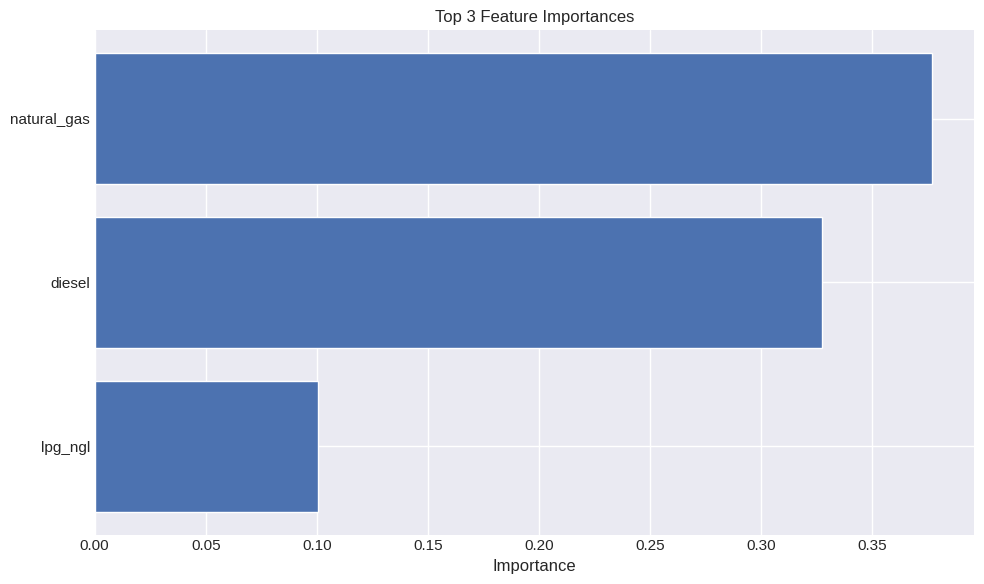

In [79]:
# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(3)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 3 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Visualize the tree

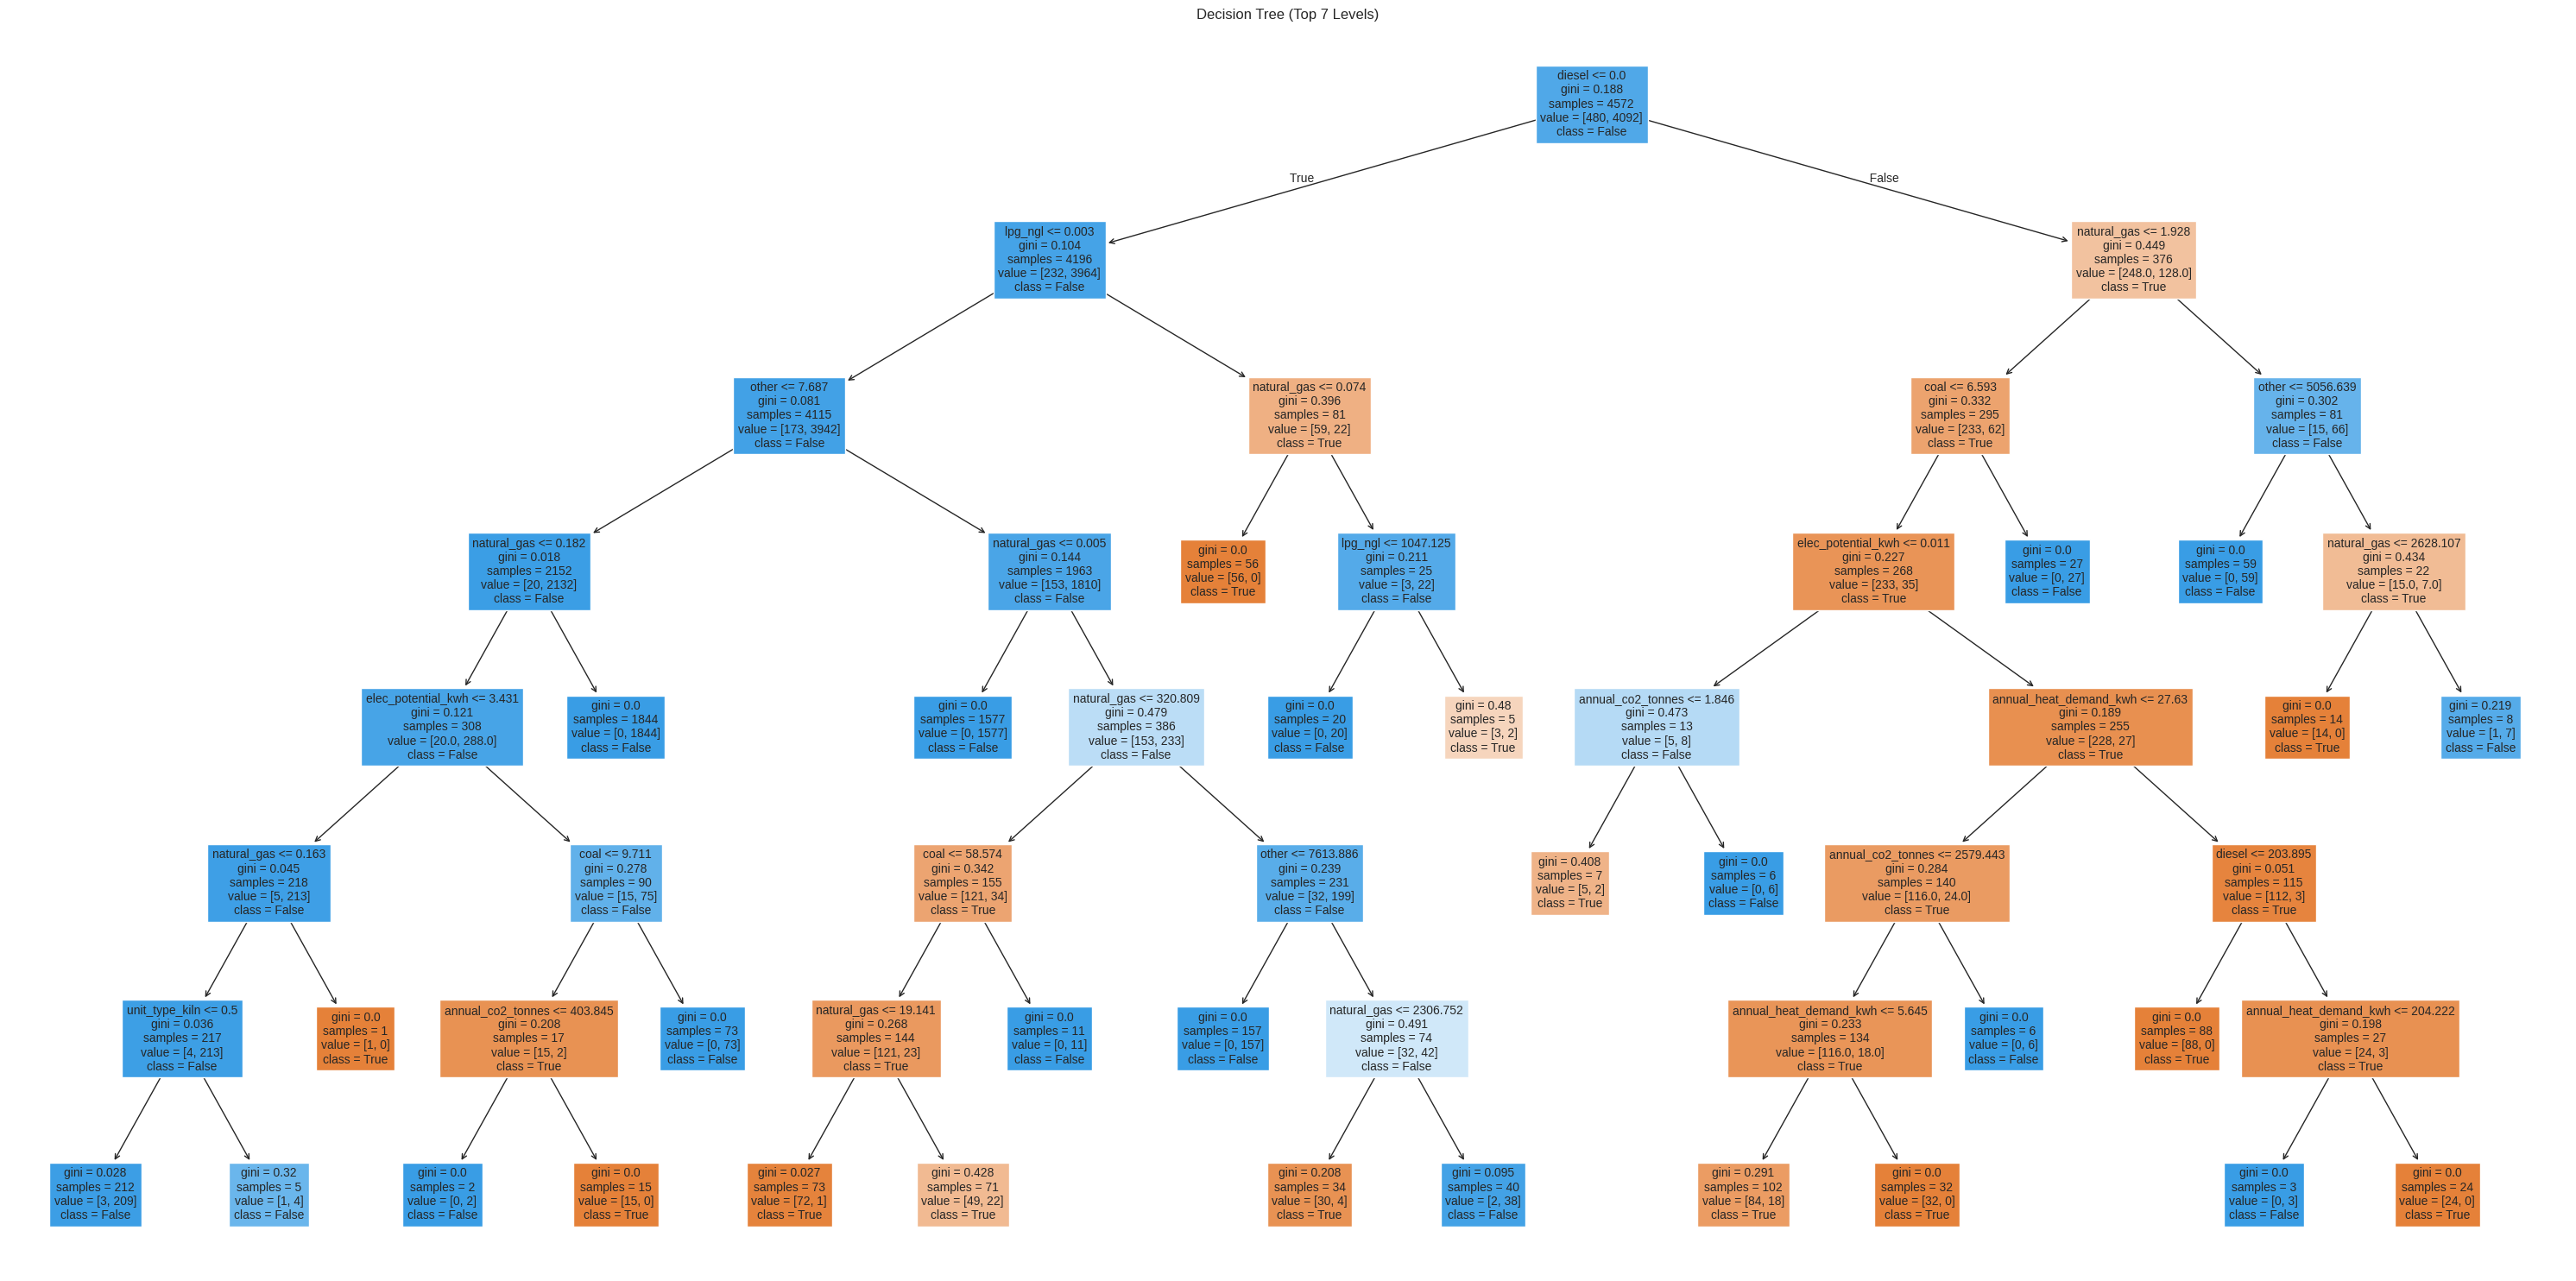

In [80]:
# Visualize the tree (simplified version)
plt.figure(figsize=(30, 15))
plot_tree(tree,
          feature_names=X_encoded.columns,
          class_names=['True', 'False'],
          filled=True,
          max_depth=7,  # only show top 3 levels
          fontsize=10)
plt.title('Decision Tree (Top 7 Levels)')
plt.tight_layout()
plt.show()

# Test other machine learning model to see if the model improve or not

# Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest with class weight
rf = RandomForestClassifier(
    n_estimators=300,  # number of trees
    max_depth=7,
    min_samples_split=5,
    class_weight={0: 10, 1: 1},  # prioritize class 0
    random_state=42,
    n_jobs=-1  # use all CPU cores
)

rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy: {accuracy:.4f}")

# Get classification report as dictionary
report = classification_report(y_test, y_pred_rf, labels=[1.0, 0.0], output_dict=True)

# Print only class 1.0 metrics without support
print("\nClassification Report (Class 1.0 only):")
print(f"Precision: {report['1.0']['precision']:.2f}")
print(f"Recall:    {report['1.0']['recall']:.2f}")
print(f"F1-Score:  {report['1.0']['f1-score']:.2f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf, labels=[1.0, 0.0]))

Random Forest Results:

Accuracy: 0.9563

Classification Report (Class 1.0 only):
Precision: 0.99
Recall:    0.96
F1-Score:  0.98

Confusion Matrix:
[[984  37]
 [ 13 110]]


# SMOTE + Random Forest

In [82]:
from imblearn.over_sampling import SMOTE

# Balance data first
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

print(f"Original class 0: {sum(y_train==0)}")
print(f"After SMOTE class 0: {sum(y_balanced==0)}")

# Train on balanced data
rf_smote = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    class_weight={0: 8, 1: 1},  # still weight but less since data is balanced
    random_state=42,
    n_jobs=-1
)

rf_smote.fit(X_balanced, y_balanced)

# Test on original test set (not resampled)
y_pred_smote = rf_smote.predict(X_test)

print("\nSMOTE + Random Forest:")

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_smote)
print(f"\nAccuracy: {accuracy:.4f}")

# Get classification report as dictionary
report = classification_report(y_test, y_pred_smote, labels=[1.0, 0.0], output_dict=True)

# Print only class 1.0 metrics without support
print("\nClassification Report (Class 1.0 only):")
print(f"Precision: {report['1.0']['precision']:.2f}")
print(f"Recall:    {report['1.0']['recall']:.2f}")
print(f"F1-Score:  {report['1.0']['f1-score']:.2f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_smote, labels=[1.0, 0.0]))

Original class 0: 480
After SMOTE class 0: 4092

SMOTE + Random Forest:

Accuracy: 0.9231

Classification Report (Class 1.0 only):
Precision: 1.00
Recall:    0.92
F1-Score:  0.96

Confusion Matrix:
[[936  85]
 [  3 120]]
